In [1]:
import os
import shutil
import subprocess
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

SIZE = 32
VARIETY = False
BATCH_SIZE = 100
AUG_RATIO = 0.20
AUG_DIST = {'A': 0.4, 'B': 0.4, 'C': 0.2}
CV_FOLDS = 3
TUNING_SUBSET_RATIO = 0.20
C_VALUES = [10, 100]
GAMMA_VALUES = [0.01, 0.001]
HIST_BINS = 32

print(f"Configuration:")
print(f"  Image size: {SIZE}x{SIZE}")
print(f"  Augmentation ratio: {AUG_RATIO*100}%")
print(f"  Augmentation dist: {AUG_DIST}")
print(f"  CV folds: {CV_FOLDS}")
print(f"  C values: {C_VALUES}")
print(f"  Gamma values: {GAMMA_VALUES}")
print(f"  Histogram bins: {HIST_BINS}")

Configuration:
  Image size: 32x32
  Augmentation ratio: 20.0%
  Augmentation dist: {'A': 0.4, 'B': 0.4, 'C': 0.2}
  CV folds: 3
  C values: [10, 100]
  Gamma values: [0.01, 0.001]
  Histogram bins: 32


In [2]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")

Dataset ready: dataset/fruit360


In [3]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]

In [4]:
transform = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

train_full = Fruit360FolderDataset(TRAIN_DIR, transform=transform, variety=VARIETY)
test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform, variety=VARIETY)

train_size = int(0.7 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

print(f"Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print(f"Classes: {len(train_full.label_to_idx)}")

Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train 91240, Val 39104, Test 43442
Classes: 79


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_loader)} train batches, {len(val_loader)} val batches, {len(test_loader)} test batches")

913 train batches, 392 val batches, 435 test batches


In [6]:
def extract_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_numpy(train_loader)
X_val, y_val = extract_numpy(val_loader)
X_test, y_test = extract_numpy(test_loader)

print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")

X_train (91240, 3, 32, 32), y_train (91240,)
X_val (39104, 3, 32, 32), y_val (39104,)
X_test (43442, 3, 32, 32), y_test (43442,)


## Augmentation: Scenario Functions

In [7]:
def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x

scenario_map = {
    'A': scenario_A,
    'B': scenario_B,
    'C': scenario_C,
}

print("Augmentation functions defined")

Augmentation functions defined


## Data Augmentation

In [8]:
np.random.seed(RANDOM_STATE)

n_augment = int(len(X_train) * AUG_RATIO)
aug_indices = np.random.choice(len(X_train), n_augment, replace=False)

scenario_counts = {'A': 0, 'B': 0, 'C': 0}

for aug_idx in aug_indices:
    r = np.random.rand()
    if r < AUG_DIST['A']:
        scenario_name = 'A'
    elif r < AUG_DIST['A'] + AUG_DIST['B']:
        scenario_name = 'B'
    else:
        scenario_name = 'C'
    
    scenario_counts[scenario_name] += 1
    
    img_tensor = torch.from_numpy(X_train[aug_idx]).float()
    aug_img = scenario_map[scenario_name](img_tensor)
    X_train[aug_idx] = aug_img.numpy()

print(f"Augmented {n_augment} images ({AUG_RATIO*100}% of training set)")
print(f"Scenario distribution: {scenario_counts}")
print(f"  A: {scenario_counts['A']/n_augment*100:.1f}%")
print(f"  B: {scenario_counts['B']/n_augment*100:.1f}%")
print(f"  C: {scenario_counts['C']/n_augment*100:.1f}%")

Augmented 18248 images (20.0% of training set)
Scenario distribution: {'A': 7293, 'B': 7358, 'C': 3597}
  A: 40.0%
  B: 40.3%
  C: 19.7%


## Preprocessing: Color Histogram Features and Scaling

In [9]:
def color_hist_features(X, bins=HIST_BINS, img_shape=(3, SIZE, SIZE)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

X_train_hist = color_hist_features(X_train, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
X_val_hist = color_hist_features(X_val, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
X_test_hist = color_hist_features(X_test, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))

print(f"Histogram features shape: {X_train_hist.shape}")

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_hist)
X_val_sc = scaler.transform(X_val_hist)
X_test_sc = scaler.transform(X_test_hist)

print(f"Features per sample: {X_train_hist.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print("Standardization done")

Histogram features shape: (91240, 96)
Features per sample: 96
Number of classes: 79
Standardization done


## LDA: Discriminative Projection

In [10]:
n_classes = len(np.unique(y_train))
lda_max_components = min(n_classes - 1, X_train_sc.shape[1])

print(f"LDA max components: {lda_max_components}")
print(f"Classes: {n_classes}")
print(f"Input feature dim: {X_train_sc.shape[1]}")

LDA max components: 78
Classes: 79
Input feature dim: 96


## Hyperparameter Tuning: 3-Fold CV on 20% Subset

In [11]:
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_sc, y_train,
    train_size=TUNING_SUBSET_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_train,
 )

print(f"Using subset of size {len(X_train_sub)} from {len(X_train_sc)} for tuning")

results = []

lda_temp = LinearDiscriminantAnalysis()
X_sub_lda = lda_temp.fit_transform(X_train_sub, y_train_sub)

for C in C_VALUES:
    for gamma in GAMMA_VALUES:
        svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)
        scores = cross_val_score(
            svm, X_sub_lda, y_train_sub,
            cv=CV_FOLDS, scoring='accuracy', n_jobs=-1,
        )
        mean_score = scores.mean()
        results.append({
            'C': C,
            'gamma': gamma,
            'cv_accuracy': mean_score,
            'cv_std': scores.std(),
        })
        print(f"C={C:3d}, gamma={gamma:.3f} -> CV acc {mean_score:.4f} (+/- {scores.std():.4f})")

results_df = pd.DataFrame(results).sort_values('cv_accuracy', ascending=False)
best_config = results_df.iloc[0]

print("\nTop 10 configurations:")
print(results_df.head(10).to_string())

print("\nBEST CONFIGURATION")
print(f"C: {best_config['C']}")
print(f"gamma: {best_config['gamma']}")
print(f"CV accuracy: {best_config['cv_accuracy']:.4f}")

Using subset of size 18248 from 91240 for tuning
C= 10, gamma=0.010 -> CV acc 0.9274 (+/- 0.0048)
C= 10, gamma=0.001 -> CV acc 0.8586 (+/- 0.0072)
C=100, gamma=0.010 -> CV acc 0.9277 (+/- 0.0048)
C=100, gamma=0.001 -> CV acc 0.9048 (+/- 0.0039)

Top 10 configurations:
     C  gamma  cv_accuracy    cv_std
2  100  0.010     0.927664  0.004761
0   10  0.010     0.927444  0.004816
3  100  0.001     0.904812  0.003900
1   10  0.001     0.858615  0.007228

BEST CONFIGURATION
C: 100.0
gamma: 0.01
CV accuracy: 0.9277


## Final Model Training on Full Augmented Training Set

In [12]:
best_C = best_config['C']
best_gamma = best_config['gamma']

print(f"Training final model with best parameters:")
print(f"  C: {best_C}")
print(f"  gamma: {best_gamma}")

lda_final = LinearDiscriminantAnalysis()
X_train_lda = lda_final.fit_transform(X_train_sc, y_train)
lda_components = X_train_lda.shape[1]

svm_final = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=RANDOM_STATE)
svm_final.fit(X_train_lda, y_train)

print(f"Final model trained (LDA components: {lda_components})")

Training final model with best parameters:
  C: 100.0
  gamma: 0.01
Final model trained (LDA components: 78)


## Validation Performance

In [13]:
X_val_lda = lda_final.transform(X_val_sc)
y_val_pred = svm_final.predict(X_val_lda)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.9993


## Test on Clean Data

In [14]:
X_test_lda = lda_final.transform(X_test_sc)
y_test_pred = svm_final.predict(X_test_lda)
test_acc_clean = accuracy_score(y_test, y_test_pred)

print(f"Test accuracy (clean): {test_acc_clean:.4f}")

Test accuracy (clean): 0.9792


## Test on Realistic Degraded Dataset (Mixed Scenarios)

In [15]:
scenarios_mixed = {
    "clean": lambda x: x,
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}

def evaluate_mixed_scenarios(test_loader, scenario_fns, probs, verbose=True):
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    
    scenario_names = list(scenario_fns.keys())
    all_preds = []
    all_labels = []
    scenario_counts = {name: 0 for name in scenario_names}
    
    start = time.time()
    
    for imgs, labels in test_loader:
        imgs_batch = []
        for img in imgs:
            r = np.random.rand()
            if r < probs[0]:
                scenario = scenario_names[0]
            elif r < probs[0] + probs[1]:
                scenario = scenario_names[1]
            elif r < probs[0] + probs[1] + probs[2]:
                scenario = scenario_names[2]
            else:
                scenario = scenario_names[3]
            
            scenario_counts[scenario] += 1
            x = scenario_fns[scenario](img)
            imgs_batch.append(x.unsqueeze(0))
        
        imgs_batch = torch.cat(imgs_batch, dim=0)
        X = imgs_batch.numpy()
        X_hist = color_hist_features(X, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
        X_hist = scaler.transform(X_hist)
        X_hist = lda_final.transform(X_hist)
        preds = svm_final.predict(X_hist)
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = (all_preds == all_labels).mean()
    elapsed = time.time() - start
    
    if verbose:
        print(f"\nAccuracy on mixed realistic distribution: {acc:.4f}")
        print(f"Time: {elapsed:.2f}s")
        print(f"Scenario distribution (actual): {scenario_counts}")
    
    return acc, elapsed, scenario_counts, all_labels, all_preds

probs_distribution = [0.60, 0.15, 0.15, 0.10]

acc_mixed, time_mixed, counts_mixed, y_true_mixed, y_pred_mixed = evaluate_mixed_scenarios(
    test_loader,
    scenarios_mixed,
    probs_distribution,
    verbose=True,
 )


Accuracy on mixed realistic distribution: 0.9382
Time: 373.26s
Scenario distribution (actual): {'clean': 26070, 'scenario_A': 6650, 'scenario_B': 6421, 'scenario_C': 4301}


## Additional Test: Alternative Distribution (50/20/20/10)

In [16]:
probs_distribution_alt = [0.50, 0.20, 0.20, 0.10]

print("Testing with alternative distribution (50% clean / 20% A / 20% B / 10% C)...")
acc_mixed_alt, time_mixed_alt, counts_mixed_alt, y_true_mixed_alt, y_pred_mixed_alt = evaluate_mixed_scenarios(
    test_loader,
    scenarios_mixed,
    probs_distribution_alt,
    verbose=True,
 )

print(f"\nComparison:")
print(f"  Standard (60/15/15/10): {acc_mixed:.4f}")
print(f"  Alternative (50/20/20/10): {acc_mixed_alt:.4f}")
print(f"  Difference: {(acc_mixed_alt - acc_mixed):.4f}")

Testing with alternative distribution (50% clean / 20% A / 20% B / 10% C)...

Accuracy on mixed realistic distribution: 0.9269
Time: 363.64s
Scenario distribution (actual): {'clean': 21927, 'scenario_A': 8659, 'scenario_B': 8570, 'scenario_C': 4286}

Comparison:
  Standard (60/15/15/10): 0.9382
  Alternative (50/20/20/10): 0.9269
  Difference: -0.0113


## Results Summary

In [17]:
results_summary = {
    'Model': 'LDA + SVM (Augmented)',
    'Image Size': f'{SIZE}x{SIZE}',
    'Augmentation': f'{AUG_RATIO*100}% (A: {AUG_DIST["A"]*100:.0f}%, B: {AUG_DIST["B"]*100:.0f}%, C: {AUG_DIST["C"]*100:.0f}%)',
    'LDA Components': lda_components,
    'C': best_C,
    'gamma': best_gamma,
    'Val Accuracy': f'{val_acc:.4f}',
    'Test Accuracy (clean)': f'{test_acc_clean:.4f}',
    'Test Accuracy (60/15/15/10)': f'{acc_mixed:.4f}',
    'Test Accuracy (50/20/20/10)': f'{acc_mixed_alt:.4f}',
}

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
for key, val in results_summary.items():
    print(f"{key:.<40} {val}")
print("="*60)

print("\nDistribution Comparison:")
print(f"  Standard (60% clean / 15% A / 15% B / 10% C): {acc_mixed:.4f}")
print(f"  Harder (50% clean / 20% A / 20% B / 10% C):   {acc_mixed_alt:.4f}")
print(f"  Accuracy drop: {(acc_mixed - acc_mixed_alt):.4f} ({(acc_mixed - acc_mixed_alt)/acc_mixed*100:.2f}%)")


FINAL RESULTS SUMMARY
Model................................... LDA + SVM (Augmented)
Image Size.............................. 32x32
Augmentation............................ 20.0% (A: 40%, B: 40%, C: 20%)
LDA Components.......................... 78
C....................................... 100.0
gamma................................... 0.01
Val Accuracy............................ 0.9993
Test Accuracy (clean)................... 0.9792
Test Accuracy (60/15/15/10)............. 0.9382
Test Accuracy (50/20/20/10)............. 0.9269

Distribution Comparison:
  Standard (60% clean / 15% A / 15% B / 10% C): 0.9382
  Harder (50% clean / 20% A / 20% B / 10% C):   0.9269
  Accuracy drop: 0.0113 (1.21%)


## Save Models

In [18]:
os.makedirs("saved_models", exist_ok=True)

suffix = "_augmented_colorhist32bins_32x32_lda"

joblib.dump(scaler, f"saved_models/scaler{suffix}.joblib")
joblib.dump(lda_final, f"saved_models/lda{suffix}.joblib")
joblib.dump(svm_final, f"saved_models/svm{suffix}.joblib")

print(f"Models saved to saved_models/:")
print(f"  - scaler{suffix}.joblib")
print(f"  - lda{suffix}.joblib")
print(f"  - svm{suffix}.joblib")

Models saved to saved_models/:
  - scaler_augmented_colorhist32bins_32x32_lda.joblib
  - lda_augmented_colorhist32bins_32x32_lda.joblib
  - svm_augmented_colorhist32bins_32x32_lda.joblib


## Classification Report

In [19]:
idx_to_label = test_dataset.idx_to_label
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

print("=" * 60)
print("Classification Report - Standard Distribution (60/15/15/10)")
print("=" * 60)
print(classification_report(y_true_mixed, y_pred_mixed, target_names=target_names, digits=3))

print("\n" + "=" * 60)
print("Classification Report - Alternative Distribution (50/20/20/10)")
print("=" * 60)
print(classification_report(y_true_mixed_alt, y_pred_mixed_alt, target_names=target_names, digits=3))

Classification Report - Standard Distribution (60/15/15/10)
              precision    recall  f1-score   support

     Almonds      0.945     0.896     0.920        77
       Apple      0.866     0.957     0.909      5506
     Apricot      0.933     0.939     0.936       164
     Avocado      0.958     0.971     0.965      1017
      Banana      0.922     0.967     0.944       645
       Beans      0.949     0.974     0.962        77
    Beetroot      0.963     0.700     0.811       150
  BlackBerry      1.000     0.979     0.990       145
 Blackberrie      0.949     0.932     0.940       600
   Blueberry      0.994     1.000     0.997       154
     Cabbage      1.000     0.969     0.984        96
      Cactus      0.882     0.951     0.915       634
        Caju      1.000     0.907     0.951        75
  Cantaloupe      0.920     0.998     0.957       484
   Carambula      0.964     0.801     0.875       166
      Carrot      0.979     0.940     0.959        50
 Cauliflower      0.9

## Confusion Matrices

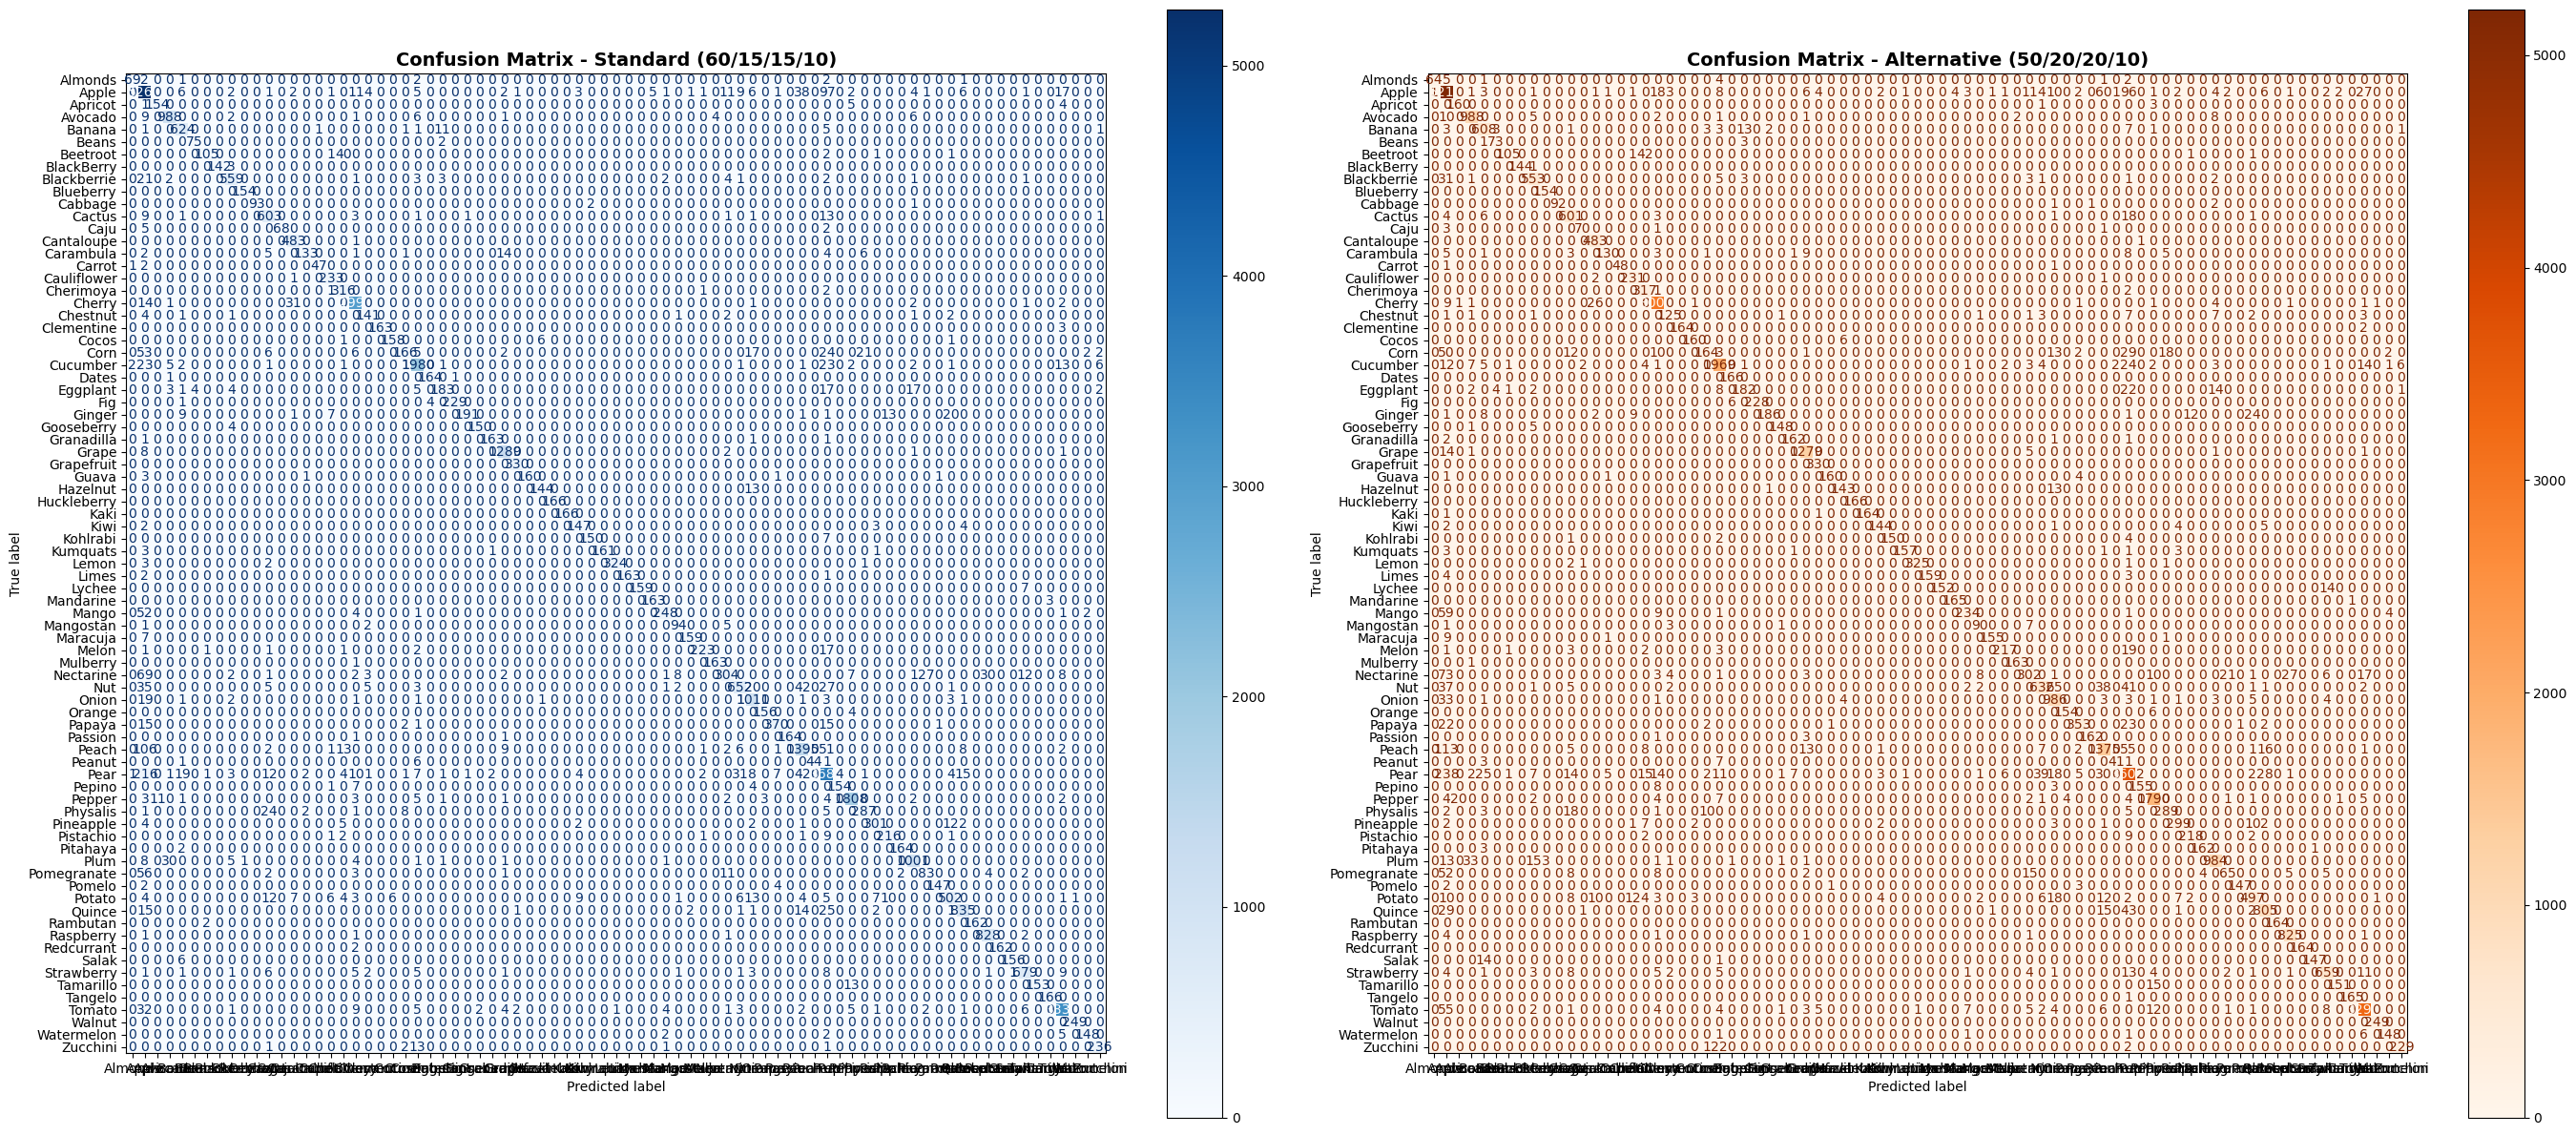


Confusion Matrix Summary:
Standard (60/15/15/10) - Correct predictions: 40758 / 43442
Alternative (50/20/20/10) - Correct predictions: 40265 / 43442


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

cm_standard = confusion_matrix(y_true_mixed, y_pred_mixed)
disp_standard = ConfusionMatrixDisplay(confusion_matrix=cm_standard, display_labels=target_names)
disp_standard.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Standard (60/15/15/10)', fontsize=14, fontweight='bold')

cm_alt = confusion_matrix(y_true_mixed_alt, y_pred_mixed_alt)
disp_alt = ConfusionMatrixDisplay(confusion_matrix=cm_alt, display_labels=target_names)
disp_alt.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('Confusion Matrix - Alternative (50/20/20/10)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Summary:")
print(f"Standard (60/15/15/10) - Correct predictions: {np.trace(cm_standard)} / {cm_standard.sum()}")
print(f"Alternative (50/20/20/10) - Correct predictions: {np.trace(cm_alt)} / {cm_alt.sum()}")